In [29]:
from __future__ import annotations

import qiskit_aer.primitives.sampler
#from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService, Options
#from qiskit import IBMQ
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, EfficientSU2
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
import qiskit.algorithms.optimizers
import sklearn.model_selection
from sklearn.datasets import fetch_covtype
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import pandas as pd
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
#import seaborn as sb
import os.path
from datetime import datetime
from math import ceil

Code is based on [the tutorial found here](https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html#Regression).
**Data preparation**

In [30]:
from IPython.core.display import Markdown
from sklearn.utils import Bunch

data_source: Bunch = fetch_covtype(data_home="./data")
Markdown(data_source.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30Ã—30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional argument 'as_frame' is
set to 'True', it will return ``data`` and ``target`` as pandas
data frame, and there will be an additional member ``frame`` as well.
The dataset will be downloaded from the web if necessary.


We define the configuration of our training session here for clarity.

In [31]:
data_frac = 0.001	# The fraction of data used for training/testing from the total dataset.
train_frac = 0.8	# The proportion of the sample used for training, with the rest reserved for testing.
num_features = 8	# The data has many features to train on, so we use PCA to reduce it to a manageable amount
batch_size = 400	# We train the model with batches of data, and this is the maximum size of a given batch
iterations = 30		# The number of times a batch is fitted to the model
shots = 512			# The number of times to run a set of circuits for
opt_level = 1		# The level of optimization for the circuits
res_level = 1		# The level of resilience hardening for the circuits
reload = True 		# Flag for if the program should load a model from memory instead of making a new one
model_filename = "covertypemodel_test1.model" # Name for loading and saving the model to disk

In [32]:
data_frame = pd.DataFrame(data=data_source.data, columns=data_source.feature_names)
#data_frame.drop(data_frame.iloc[:, -44:], axis=1, inplace=True)
data_frame["Cover_Type"] = pd.Series(data_source.target)-1
data_frame = data_frame.sample(frac=data_frac)
display(data_frame)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
123136,2989.0,330.0,19.0,201.0,12.0,4494.0,173.0,214.0,179.0,212.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
315194,3032.0,78.0,8.0,0.0,0.0,883.0,231.0,226.0,128.0,190.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
99957,2625.0,125.0,13.0,300.0,69.0,295.0,242.0,230.0,115.0,1154.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
367174,2714.0,7.0,12.0,30.0,2.0,2730.0,205.0,215.0,147.0,524.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
284136,2405.0,139.0,13.0,295.0,164.0,295.0,239.0,236.0,124.0,1828.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554599,3366.0,221.0,19.0,768.0,221.0,1103.0,194.0,254.0,191.0,4302.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
44474,2962.0,325.0,19.0,277.0,102.0,6145.0,168.0,215.0,185.0,4712.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
473568,2873.0,225.0,25.0,134.0,36.0,808.0,177.0,254.0,203.0,691.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
327289,3064.0,31.0,11.0,60.0,7.0,1622.0,217.0,216.0,133.0,886.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Separate the features and the labels (which is our target). We also preprocess the features and labels (normalizing and categorizing respectively)

In [33]:
features = data_frame.iloc[:, 0:-1].values
features = PCA(n_components=num_features).fit_transform(features)
labels = data_frame.loc[:, "Cover_Type"].values
features = StandardScaler().fit_transform(features)
labels = OrdinalEncoder().fit_transform(labels.reshape(-1,1))[:,0]
display(features, features.shape)
display(labels, labels.shape)
#sb.stripplot(data=data_frame.sample(frac=0.05), y="Cover_Type", hue="Cover_Type")

array([[ 0.48963816, -2.28025395, -0.55258096, ..., -0.66483748,
         0.14375179,  1.3006289 ],
       [-1.25991755, -0.59340911, -0.13421064, ..., -0.06118799,
        -0.04396453, -0.71883557],
       [-1.24030976,  0.37170809, -0.61383451, ...,  0.08663442,
         0.87251038, -1.33175973],
       ...,
       [-1.13725594, -0.20332002, -0.31563768, ...,  0.1959575 ,
        -1.57847316, -0.88670097],
       [-0.67550632, -0.45388257, -0.06061395, ...,  0.08527031,
        -0.7066052 ,  0.05479811],
       [-0.11339777, -0.72364242,  3.50981971, ...,  4.41209389,
         3.67560779, -0.43267566]])

(581, 8)

array([1., 0., 1., 1., 3., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 2., 1., 0., 0., 1., 0., 1., 0., 0., 2., 0., 4.,
       0., 2., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 4., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 2., 2., 1., 1., 6., 0., 1., 1., 1., 5., 5.,
       0., 0., 1., 0., 1., 1., 2., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       5., 1., 1., 1., 1., 1., 5., 0., 0., 4., 0., 1., 1., 0., 0., 1., 1.,
       6., 1., 1., 1., 1., 2., 1., 5., 1., 0., 5., 0., 1., 1., 1., 0., 4.,
       1., 2., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 4., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 6., 0., 1., 1., 5., 1., 6., 0., 0., 1., 1., 0., 0., 1.,
       1., 2., 0., 1., 0., 1., 1., 1., 5., 0., 0., 1., 0., 1., 1., 5., 2.,
       1., 5., 1., 0., 0.

(581,)

We separate the now preprocessed data into a training set and a test set with a 80:20 split.

In [34]:
train_features, test_features, train_labels, test_labels = sklearn.model_selection.train_test_split(
	features,
	labels,
	train_size=train_frac
)
display(train_features.shape, train_labels.shape, test_features.shape, test_labels.shape)

(464, 8)

(464,)

(117, 8)

(117,)

We also separate the data into batches for more time-efficient learning

In [35]:
from sklearn.utils import gen_batches

train_slices = gen_batches(train_features.shape[0], batch_size)

**Custom Ansatz**
We create a custom ansatz here that we are able to tweak. This enables the neural network to make better guesses which allows for faster convergence.

In [36]:
import math
from qiskit.circuit import ParameterVector, Parameter
from qiskit import QuantumRegister, ClassicalRegister
from typing import Callable
from qiskit.circuit.library import NLocal, RYGate, CXGate

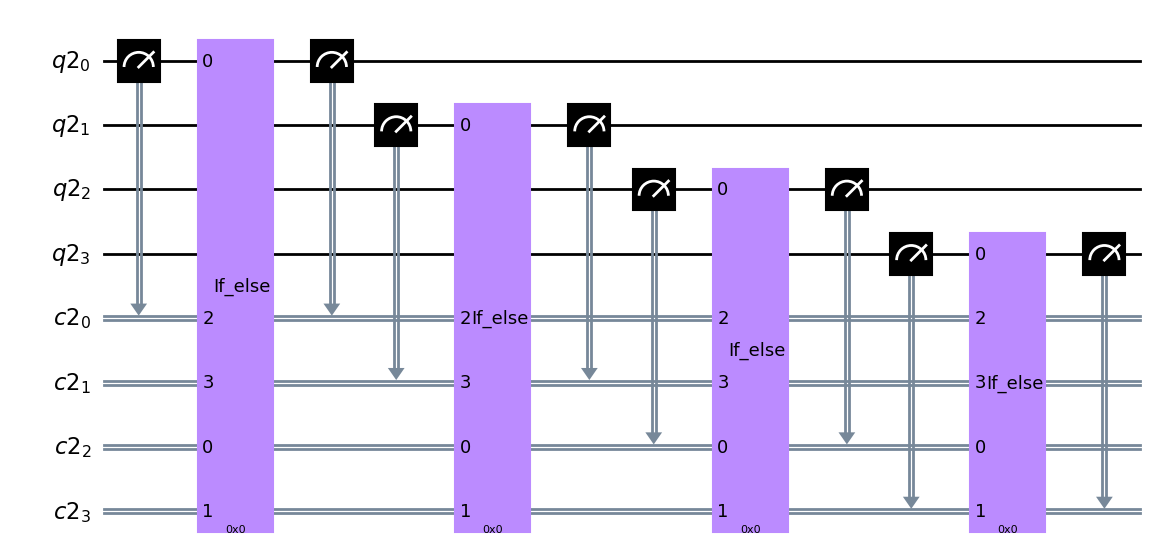

In [37]:
def DynamicFinalRotationBlockFactory(num_qubits:int) -> QuantumCircuit:
	q_reg = QuantumRegister(num_qubits)
	c_reg = ClassicalRegister(num_qubits)

	circuit = QuantumCircuit(q_reg, c_reg)
	for i in range(0, num_qubits, 1):
		param0 = Parameter(name=f"Ш0[{i}]") # Ш0 (sha) represents the rotations if the qubit measure to 0.
		param1 = Parameter(name=f"Ш1[{i}]") # Ш1 (sha) represents the rotations if the qubit measure to 1.

		# We measure the circuit as if at the end, seeing if we'd get a 1 or 0
		circuit.measure(q_reg[i], c_reg[i])

		# The if test can see if it is a 1 or 0, and lets the model apply a final rotation
		# to change the results based on its output
		with circuit.if_test((c_reg, 0)) as else_:
			circuit.h(i)
			circuit.ry(param0,i)
		with else_:
			circuit.h(i)
			circuit.ry(param1,i)

		# We then finally measure the results, as otherwise the sampler cries
		circuit.measure(q_reg[i], c_reg[i])

	return circuit
DynamicFinalRotationBlockFactory(4).draw(output="mpl")

**Creating the QNN**
We now will make the QNN to process our data.

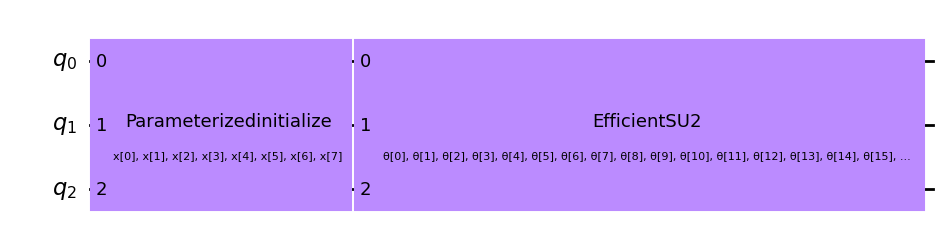

In [38]:
from qiskit_machine_learning.circuit.library import RawFeatureVector

#feature_map = ZZFeatureMap(num_features)
feature_map = RawFeatureVector(num_features)
ansatz = EfficientSU2(feature_map.num_qubits, skip_final_rotation_layer=True)

'''
dynamic_block = DynamicFinalRotationBlockFactory(feature_map.num_qubits)
ansatz.compose(dynamic_block, inplace=True)
'''

circuit = QuantumCircuit(feature_map.num_qubits)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)

#ansatz.decompose().draw(output="mpl")
circuit.draw(output="mpl")

In [39]:
from qiskit_aer import AerSimulator

def interpret(x):
	return x%7

service: QiskitRuntimeService = QiskitRuntimeService(
	channel='ibm_quantum',
	instance='ibm-q-asu/main/pi-deluca',
)

options = Options()
options.execution.shots = shots
options.optimization_level = opt_level
options.resilience_level = res_level
#options.transpilation.skip_transpilation = True


#backend = service.least_busy(min_num_qubits=feature_map.num_qubits, filters=lambda b: (b.configuration().simulator == True) and (b.configuration().conditional == True))
backend = service.get_backend("simulator_statevector")
print(backend.name)
#custom_sampler = Sampler(session=backend, options=options)

#custom_sampler = qiskit_aer.primitives.Sampler()
custom_sampler = qiskit.primitives.Sampler()

sampler = SamplerQNN(sampler=custom_sampler,
					 circuit=circuit,
					 input_params=feature_map.parameters,
					 weight_params=ansatz.parameters,
					 interpret=interpret,
					 output_shape=7
					 )
sampler.input_gradients = True

simulator_statevector


In [40]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.clf()
def callback_graph(weights, obj_func_eval):
	clear_output(wait=True)
	objective_func_vals.append(obj_func_eval)
	plt.title("Objective function value against iteration")
	plt.xlabel("Iteration")
	plt.ylabel("Objective function value")
	plt.plot(range(len(objective_func_vals)), objective_func_vals, color=(0.8,0.5,0.8))
	plt.show()

<Figure size 1200x600 with 0 Axes>

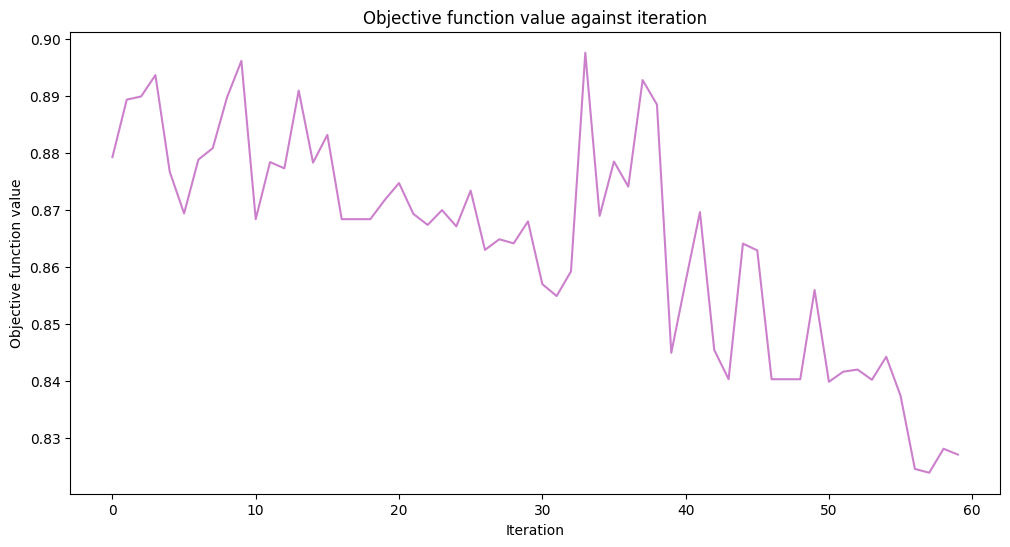

Model trained at 2023-08-29 12:24:43.891736, for a total time of 0:02:33.646856


In [41]:
from qiskit_machine_learning import QiskitMachineLearningError
if not reload:
	classifier = NeuralNetworkClassifier(
	sampler,
	one_hot=True,
	optimizer=qiskit.algorithms.optimizers.COBYLA(maxiter=iterations),
	callback=callback_graph,
	warm_start=True
)
else:
	classifier = NeuralNetworkClassifier.load(model_filename)
plt.clf()
start = datetime.now()
display(f"Model started training at {str(start)}")
for chunk in train_slices:
	"""
	try:
		classifier.fit(train_features[chunk], train_labels[chunk])
	except QiskitMachineLearningError as e:
		display(f"Error in slice {chunk}: {e.message}")
		display(e.__traceback__)
	else:
		# We save our current progress after each round of training, in case it errors out
		classifier.save(model_filename)
	"""

	classifier.fit(train_features[chunk], train_labels[chunk])
	classifier.save(model_filename)

finish = datetime.now()
print(f"Model trained at {str(finish)}, for a total time of {str(finish-start)}")

In [42]:
testing_score = classifier.score(test_features, test_labels)
print(f"Test dataset score:     {testing_score:.6f}")
training_score = classifier.score(train_features, train_labels)
print(f"Training dataset score: {training_score:.6f}")

Test dataset score:     0.188034
Training dataset score: 0.247845
